In [3]:
from google.cloud import bigquery
import uuid
from pandas.io.gbq import read_gbq
import pandas as pd
import numpy as np
from fbprophet import Prophet
%matplotlib inline

bigquery_client = bigquery.Client()

In [216]:
# query day by day
query = '''#standardSQL
SELECT
  date(created_date), count(unique_key)
FROM
  `bigquery-public-data.new_york.311_service_requests`
GROUP BY
date(created_date)
'''
general_volume = pd.read_gbq(query=query, project_id='resonant-hawk-125714', dialect='standard')

Traceback (most recent call last):
  File "/Users/mfumagalli/anaconda/lib/python2.7/site-packages/googleapiclient/discovery_cache/__init__.py", line 41, in autodetect
    from . import file_cache
  File "/Users/mfumagalli/anaconda/lib/python2.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    'file_cache is unavailable when using oauth2client >= 4.0.0')
ImportError: file_cache is unavailable when using oauth2client >= 4.0.0
INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/discovery/v1/apis/bigquery/v2/rest
INFO:googleapiclient.discovery:URL being requested: POST https://www.googleapis.com/bigquery/v2/projects/resonant-hawk-125714/jobs?alt=json
Traceback (most recent call last):
  File "/Users/mfumagalli/anaconda/lib/python2.7/site-packages/googleapiclient/discovery_cache/__init__.py", line 41, in autodetect
    from . import file_cache
  File "/Users/mfumagalli/anaconda/lib/python2.7/site-packages/googleapiclient/d

Requesting query... 

INFO:googleapiclient.discovery:URL being requested: POST https://www.googleapis.com/bigquery/v2/projects/resonant-hawk-125714/jobs?alt=json


ok.
Job ID: job_rvskjBfknah7ClsggPkRdBw1_fWT
Query running...


INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/bigquery/v2/projects/resonant-hawk-125714/queries/job_rvskjBfknah7ClsggPkRdBw1_fWT?alt=json


Query done.
Processed: 245.3 MB
Standard price: $0.00 USD

Retrieving results...
Got 2822 rows.

Total time taken 3.1 s.
Finished at 2017-09-23 13:21:43.


# MODEL WITH NO COVARIATES


In [263]:
general_volume.head()
general_volume.to_pickle('volume_of_calls.csv')
general_volume.columns=['ds','y']

,f0_,f1_
0,2011-11-20,3072
1,2011-10-01,3072
2,2014-03-02,4096
3,2014-07-27,4096
4,2012-07-20,4608


In [95]:
m = Prophet()
m.fit(general_volume)

future = m.make_future_dataframe(periods=0)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
2817,2017-09-18,7283.149483,6216.881323,8345.003689
2818,2017-09-19,7408.545027,6411.102746,8542.310388
2819,2017-09-20,7290.081141,6258.716282,8336.012289
2820,2017-09-21,7091.463190,6112.075408,8105.183651
2821,2017-09-22,6778.816473,5715.415689,7833.203436


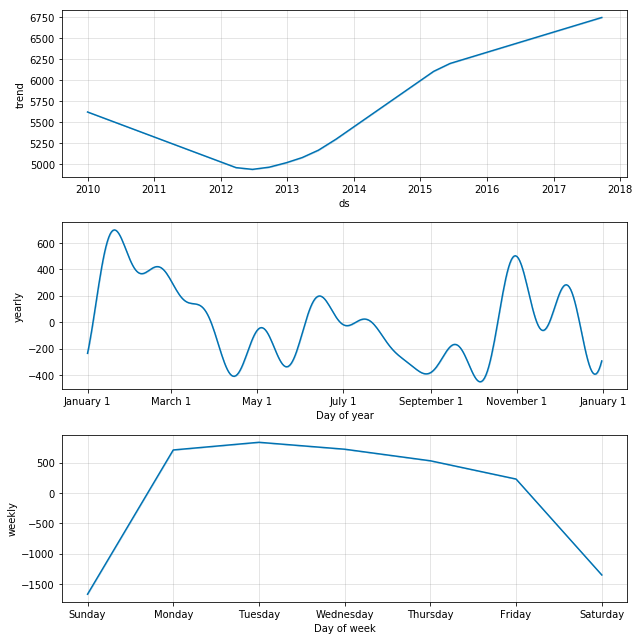

In [96]:

m.plot_components(forecast);


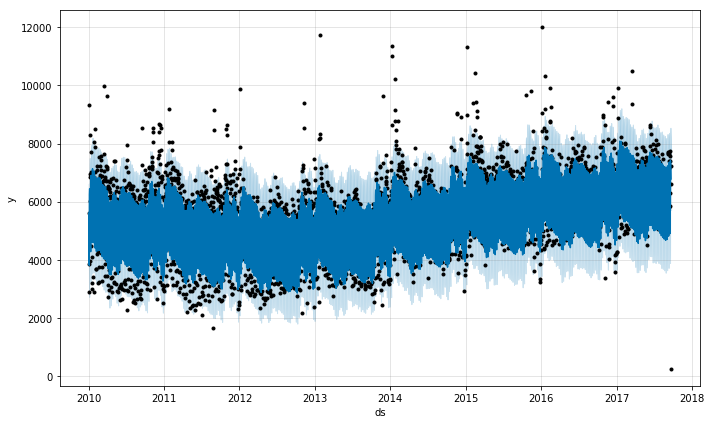

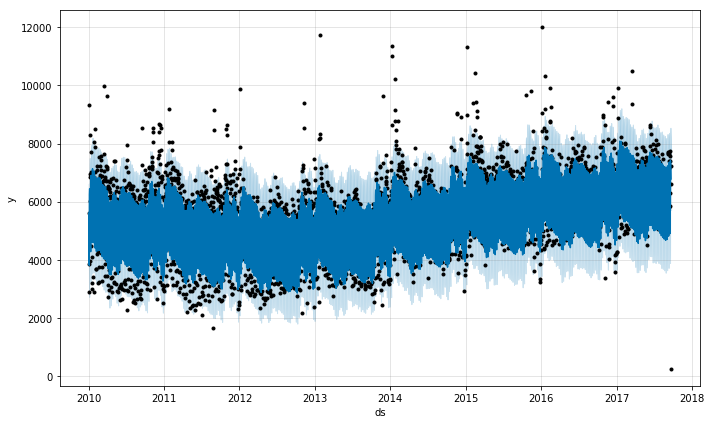

In [128]:
m.plot(forecast)


In [109]:
general_volume['ds']=general_volume.ds.astype('datetime64[ns]')
joined_df = general_volume.merge(forecast, left_on='ds', right_on='ds')

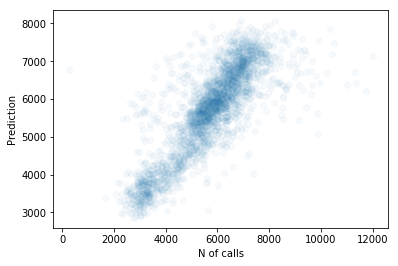

In [126]:
plt.scatter(joined_df.y, joined_df.yhat, alpha=0.03)
r2_score(joined_df.y, joined_df.yhat)
plt.xlabel('N of calls')
plt.ylabel('Prediction')

# ADD WEATHER BASED DATA

In [130]:
# add weather 
df=pd.DataFrame()
for year in range(2010,2018):
    df_year=pd.read_csv('../311NYC/WeatherUnderground/output/'+str(year)+'.csv')
    df=df.append(df_year)
df['Date']=df['Date'].astype('datetime64[ns]')


In [143]:
volume_weather=general_volume.merge(df, left_on='ds' , right_on='Date')
volume_weather.head()

# i need to kill 2 days with no data
volume_weather=volume_weather[~volume_weather.T_avg.isnull()]

,ds,y,Date,DP_avg,DP_high,DP_low,Day,H_avg,H_high,H_low,...,V_avg,V_high,V_low,W_avg,W_high,W_low,event,Month,Year,Date.1
0,2011-10-01,3072,2011-10-01,56.0,61.0,45.0,1,87.0,100.0,73.0,...,7.0,10.0,2.0,13.0,18.0,5.0,Rain,Oct,2011,2011-10-01
1,2011-11-20,3072,2011-11-20,45.0,49.0,42.0,20,66.0,80.0,52.0,...,10.0,10.0,10.0,16.0,26.0,9.0,\t,Nov,2011,2011-11-20
2,2014-03-02,4096,2014-03-02,18.0,23.0,14.0,2,46.0,52.0,40.0,...,10.0,10.0,9.0,13.0,20.0,4.0,\t,Mar,2014,2014-03-02
3,2014-07-27,4096,2014-07-27,67.0,71.0,62.0,27,72.0,93.0,51.0,...,9.0,10.0,6.0,12.0,17.0,3.0,Rain,Jul,2014,2014-07-27
4,2012-07-20,4608,2012-07-20,63.0,67.0,60.0,20,87.0,100.0,73.0,...,6.0,10.0,1.0,18.0,26.0,7.0,Rain,Jul,2012,2012-07-20


/Users/mfumagalli/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=6,center=False).mean()
  app.launch_new_instance()
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


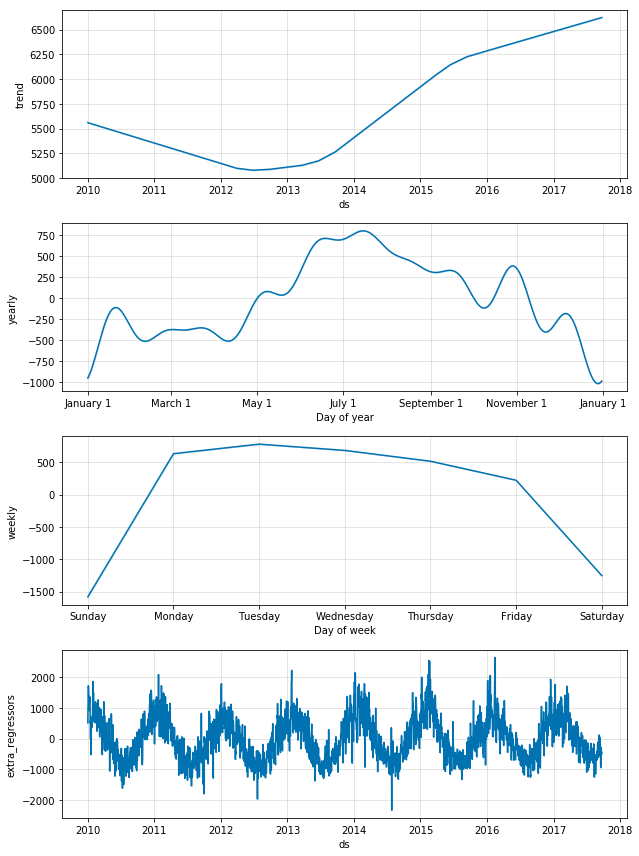

In [208]:
m = Prophet()


def snow(x):
    if x.event =='Snow':
        return x.R_sum
    else:
        return 0

volume_weather['snow'] = volume_weather.apply(lambda x: snow(x), axis=1)


volume_weather['y_minus_1']=volume_weather.y.shift(1)
volume_weather['y_minus_2']=volume_weather.y.shift(2)

volume_weather['mean_previous_week']=pd.rolling_mean(volume_weather.y, window=6)
volume_weather=volume_weather.fillna(0) # for the first day when we have no info

regressors = ['T_avg','R_sum', 'W_high', 'H_high','T_high','T_low','DP_high', 'snow','y_minus_2','y_minus_1','mean_previous_week']
for r in regressors:
    m.add_regressor(r)
m.fit(volume_weather)
#future_weather = m.make_future_dataframe(periods=0)
regressors.append('ds')
future_weather=volume_weather[regressors]

forecast = m.predict(future_weather)
m.plot_components(forecast);

joined_df = volume_weather.merge(forecast, left_on='ds', right_on='ds')

0.740414174118


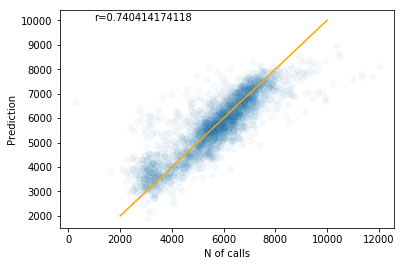

In [214]:
plt.scatter(joined_df.y, joined_df.yhat, alpha=0.03)
print r2_score(joined_df.y, joined_df.yhat)
plt.xlabel('N of calls')
plt.plot([2000,10000],[2000,10000], color='orange')
plt.text(1000,10000,"r="+str(r2_score(joined_df.y, joined_df.yhat)))
plt.ylabel('Prediction')

# TRY A RANDOM FOREST

In [260]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
 
    
from sklearn.model_selection import train_test_split
features=regressors
volume_weather['dayofweek']=volume_weather.Date.apply(lambda x: x.dayofweek)
volume_weather['day']=volume_weather.Date.apply(lambda x: x.day)
volume_weather['month']=volume_weather.Date.apply(lambda x: x.month)
# features.remove('ds')
features.append('dayofweek')
features.append('day')
features.append('month')

X_train, X_test, y_train, y_test = train_test_split(volume_weather[features], volume_weather['y'], test_size=0.33, random_state=422)
    
num_features = volume_weather[features].shape[1]
# Use at most half of the features
max_features= 20
max_features = max(1, min(int(volume_weather[regressors].shape[1] / 2), max_features))
estimator = ExtraTreesRegressor(max_features=max_features,n_estimators=1000)

estimator.fit(X_train, y_train)


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=10, max_leaf_nodes=None, min_impurity_split=1e-07,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [261]:
Yhat_test=estimator.predict(X_test)

0.817305455891


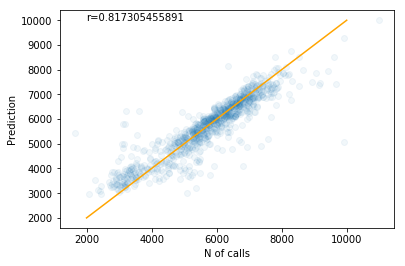

In [262]:
plt.scatter(y_test,Yhat_test, alpha=0.06)
print r2_score(y_test,Yhat_test)
plt.xlabel('N of calls')
plt.plot([2000,10000],[2000,10000], color='orange')
plt.text(2000,10000,"r="+str(r2_score(y_test,Yhat_test)))
plt.ylabel('Prediction')